In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler

pd.pandas.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('../data/train_cleaned1.csv')
final_df = pd.read_csv('../data/test_cleaned1.csv')

# Lets create some cool new predictor features!
I want to make a feature for the livable area in the basement as that is a big feature when buying a home

In [4]:
df['basement_livable'] = df['Total Bsmt SF'] - df['Bsmt Unf SF']


I also want to add a total square footage feature 

In [5]:
df['Total_sf'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']

#### Neighborhoods are also a big factor in price in real life
I want to figure out a way to break the many neighborhoods down to a handful in groups that have a relative quality score
I cant base the composite feature of the target of sales price so I will go off of each neighborhoods relation to:
- Overall qual
- overall cond
- functional
- exterior cond
- exterion qual
- kitchen qual 

replacing this category will also get rid of dummy count

In [6]:
# Creating a new numeric ordinal variable for 'Functional'
def functional_numeric(x):
    if 'Typ' in x:
        return 8
    elif 'Min1' in x:
        return 7
    elif 'Min2' in x:
        return 6
    elif 'Mod' in x:
        return 5
    elif 'Maj1' in x:
        return 4
    elif 'Maj2' in x:
        return 3
    elif 'Sev' in x:
        return 2    
    else:
        return 1
    
df['Functional_Num'] = df['Functional'].map(functional_numeric)

In [7]:
# Creating a new numeric ordinal variable for external conditon
def extercond_numeric(x):
    if 'Ex' in x:
        return 5
    elif 'Gd' in x:
        return 4
    elif 'TA' in x:
        return 3
    elif 'Fa' in x:
        return 2
    else:
        return 1
    
df['ExterCond_Num'] = df['Exter Cond'].map(extercond_numeric)
df['ExterQual_Num'] = df['Exter Qual'].map(extercond_numeric)#Same categories 
df['KitchenQual_Num'] = df['Kitchen Qual'].map(extercond_numeric)#Same categories

In [8]:
print(df['Overall Qual'].mean())
print(df['Overall Cond'].mean())
print(df['ExterQual_Num'].mean())
print(df['ExterCond_Num'].mean())
print(df['Functional_Num'].mean())
print(df['KitchenQual_Num'].mean())

6.108345534407028
5.5627135187896535
3.4045876037091265
3.0722303562713518
7.817471937530502
3.5158613958028306


In [9]:
df['neigh_score'] = ((df['Overall Qual']/df['Overall Qual'].mean()) 
+ (df['Overall Cond']/df['Overall Cond'].mean())
+ (df['ExterQual_Num']/df['ExterQual_Num'].mean())
+ (df['ExterCond_Num']/df['ExterCond_Num'].mean()) 
+ (df['Functional_Num']/df['Functional_Num'].mean()))
+ (df['KitchenQual_Num']/df['KitchenQual_Num'].mean())

0       1.137701
1       1.137701
2       1.137701
3       0.853276
4       0.853276
          ...   
2044    1.137701
2045    0.853276
2046    0.853276
2047    0.853276
2048    1.137701
Name: KitchenQual_Num, Length: 2049, dtype: float64

In [10]:
neigh_score_data =pd.DataFrame(df['neigh_score'].groupby(df['Neighborhood']).mean().sort_values().reset_index())
neigh_score_data 

,Neighborhood,neigh_score
0,IDOTRR,4.469008
1,MeadowV,4.640433
2,Edwards,4.665773
3,SWISU,4.784277
4,Sawyer,4.799314
5,NAmes,4.836293
6,BrkSide,4.851102
7,Mitchel,4.860030
8,ClearCr,4.881989
9,OldTown,4.890897


In [11]:
df['neigh_score'].mean()

5.000000000000016

In [12]:
def final_score(x):
    if 'MeadowV' in x or 'Edwards' in x or 'Sawyer' in x or 'SWISU' in x or 'IDOTRR' in x:
        return 1
    elif 'NAmes' in x or 'Mitchel' in x or 'BrkSide' in x or 'OldTown' in x or 'ClearCr' in x or 'Gilbert' in x:
        return 2
    elif 'SawyerW' in x or 'NWAmes' in x or 'Crawfor' in x or 'CollgCr' in x or 'Rare_var' in x or 'Blmngtn' in x:
        return 3
    else:
        return 4

In [13]:
df['Neighborhood'] = df['Neighborhood'].map(final_score)
df.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Lot Frontage_nans,Mas Vnr Area_nans,BsmtFin SF 1_nans,BsmtFin SF 2_nans,Bsmt Unf SF_nans,Total Bsmt SF_nans,Bsmt Full Bath_nans,Bsmt Half Bath_nans,Garage Yr Blt_nans,Garage Cars_nans,Garage Area_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score
0,109,533352170,60,RL,4.219508,9.511703,Pave,Missing,IR1,Lvl,AllPub,CulDSac,Gtl,1,RRAe,Norm,1Fam,2Story,6,8,34,5,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,6.586172,754,0,7.299121,0.0,0.0,2,1,3,1,Gd,6,Typ,0,Missing,Attchd,34.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,Missing,Missing,Missing,0,3,2010,WD,11.779129,1,0,0,0,0,0,0,0,0,0,0,533.0,1485.586172,8,3,4,4,5.595133
1,544,531379050,60,RL,3.761200,9.349406,Pave,Missing,IR1,Lvl,AllPub,CulDSac,Gtl,1,Norm,Norm,1Fam,2Story,7,5,13,12,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,6.816736,1209,0,7.660114,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,12.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,Missing,Missing,Missing,0,4,2009,WD,12.301383,0,0,0,0,0,0,0,0,0,0,0,637.0,2128.816736,8,3,4,4,5.219538


# Now to make last transformations

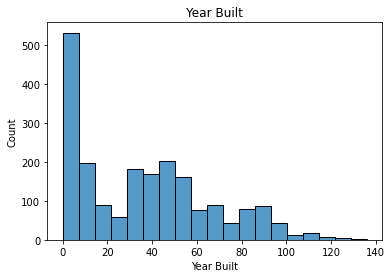

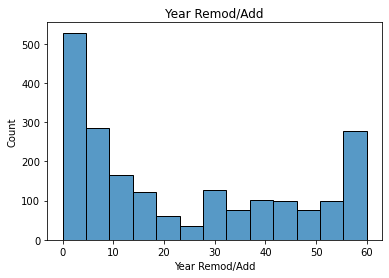

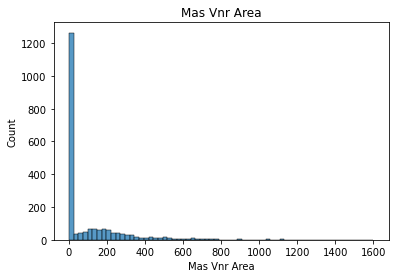

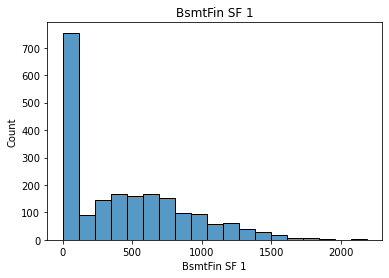

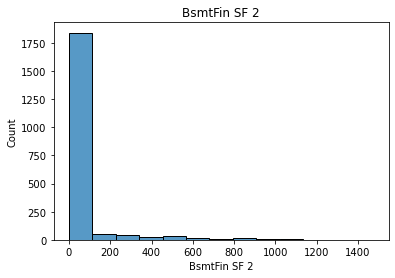

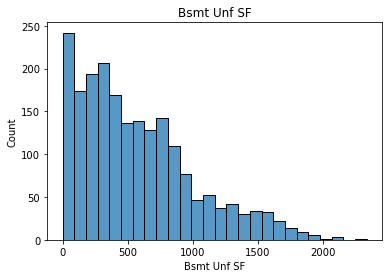

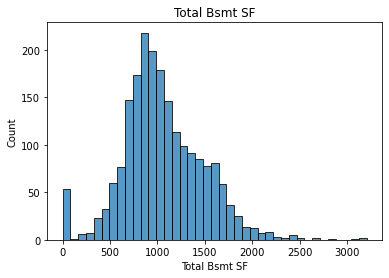

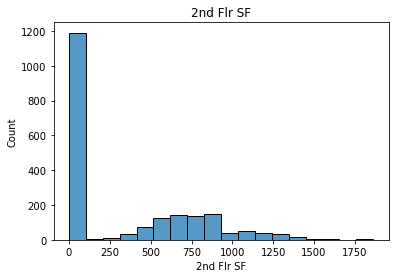

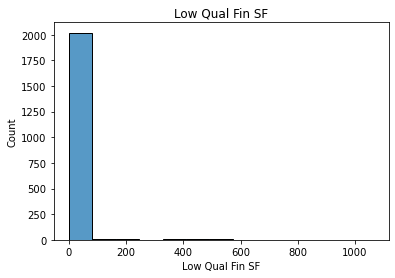

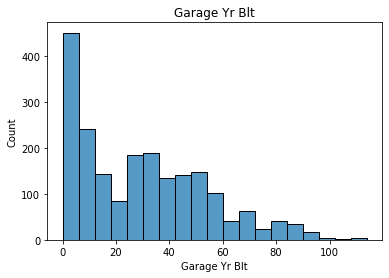

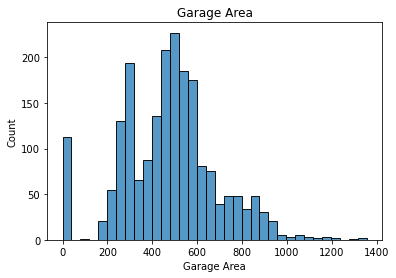

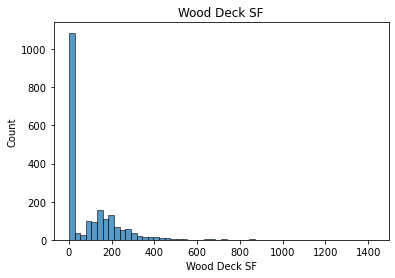

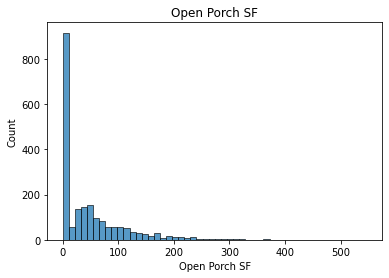

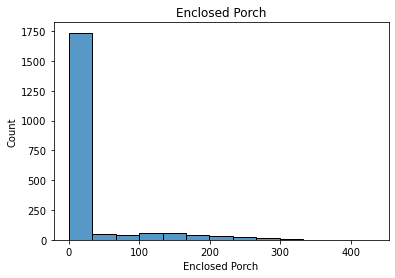

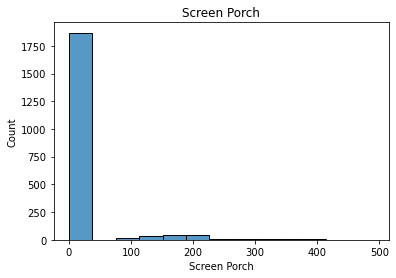

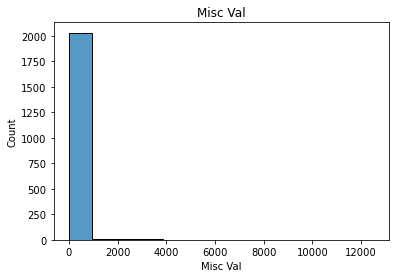

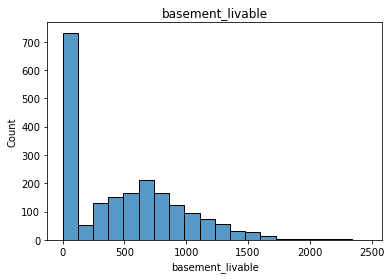

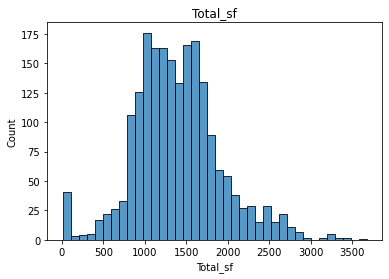

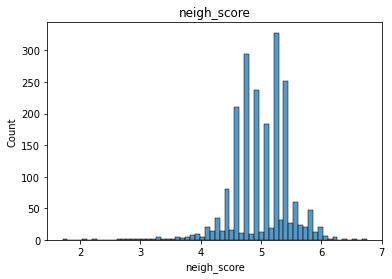

In [14]:
#Visualize non log transformed continuous features to see if any would be good candidates for root transform
#in order to standardize distributions 
numeric_features = df._get_numeric_data().columns
continuous_features = [feature for feature in numeric_features if len(df[feature].unique())>25 and feature not in ['Id','PID']]
log_transformed = ['Lot Frontage', 'Lot Area', '1st Flr SF', 'Gr Liv Area', 'SalePrice']
maybe_root = [feature for feature in continuous_features if feature not in log_transformed]

for a in maybe_root:
    plot = sns.histplot(df[a])
    plt.title(a)
    plt.show()

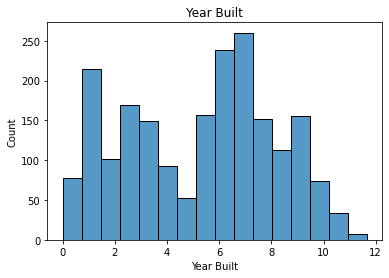

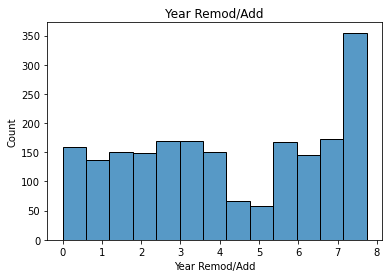

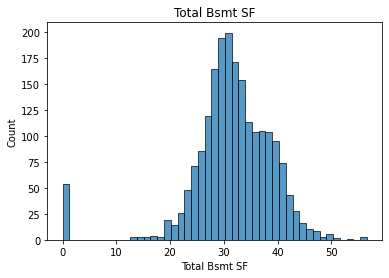

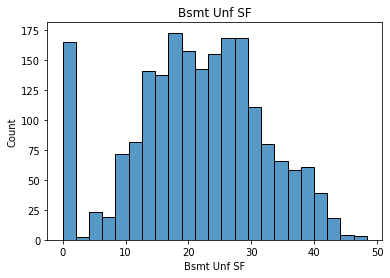

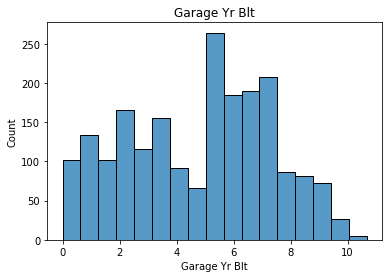

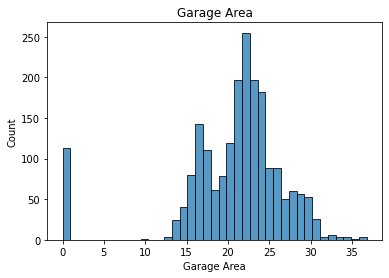

In [15]:
#Only 3 of the area measures and 3 of the year measures seemede great candidates
#they do in fact look a good deal more normalized 
columns_root_transform = ['Year Built', 'Year Remod/Add', 'Total Bsmt SF','Bsmt Unf SF', 'Garage Yr Blt', 'Garage Area']
for feature in columns_root_transform:
        plot = sns.histplot(np.sqrt(df[feature]))
        plt.title(feature)
        plt.show()

In [16]:
for feature in columns_root_transform:
        df[feature] = np.sqrt(df[feature])
        
df[columns_root_transform].head(3)

,Year Built,Year Remod/Add,Total Bsmt SF,Bsmt Unf SF,Garage Yr Blt,Garage Area
0,5.830952,2.236068,26.925824,13.856406,5.830952,21.794495
1,3.605551,3.464102,30.215890,16.613248,3.464102,23.643181
2,7.549834,1.732051,32.511536,18.055470,7.549834,15.684387


In [17]:
df.isnull().sum().sum()

0

## Repeat ALL for final test data

In [18]:
final_df['basement_livable'] = final_df['Total Bsmt SF'] - final_df['Bsmt Unf SF']

In [19]:
final_df['Total_sf'] = final_df['Total Bsmt SF'] + final_df['1st Flr SF'] + final_df['2nd Flr SF']

In [20]:
#Now to transform the final test submission data to have this feature
def add_neigh_score_continuous(df):

    def functional_numeric(x):
        if 'Typ' in x:
            return 8
        elif 'Min1' in x:
            return 7
        elif 'Min2' in x:
            return 6
        elif 'Mod' in x:
            return 5
        elif 'Maj1' in x:
            return 4
        elif 'Maj2' in x:
            return 3
        elif 'Sev' in x:
            return 2    
        else:
            return 1
    
    def extercond_numeric(x):
        if 'Ex' in x:
            return 5
        elif 'Gd' in x:
            return 4
        elif 'TA' in x:
            return 3
        elif 'Fa' in x:
            return 2
        else:
            return 1
    
    df['Functional_Num'] = df['Functional'].map(functional_numeric)
    df['ExterCond_Num'] = df['Exter Cond'].map(extercond_numeric)
    df['ExterQual_Num'] = df['Exter Qual'].map(extercond_numeric)#Same categories 
    df['KitchenQual_Num'] = df['Kitchen Qual'].map(extercond_numeric)#Same categories
    df['neigh_score'] = ((df['Overall Qual']/df['Overall Qual'].mean()) 
    + (df['Overall Cond']/df['Overall Cond'].mean())
    + (df['ExterQual_Num']/df['ExterQual_Num'].mean())
    + (df['ExterCond_Num']/df['ExterCond_Num'].mean()) 
    + (df['Functional_Num']/df['Functional_Num'].mean()))
    + (df['KitchenQual_Num']/df['KitchenQual_Num'].mean())
    return df

In [21]:
final_df = add_neigh_score_continuous(final_df)
final_df.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Lot Frontage_nans,Mas Vnr Area_nans,Garage Yr Blt_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score
0,2658,902301120,190,RM,4.234107,9.120634,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,96,56,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Rare_var,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,Rare_var,6.811244,1020,0,7.564238,0,0,2,0,4,2,Fa,9,Typ,0,Missing,Detchd,96.0,Unf,1,440,Rare_var,Rare_var,Y,0,60,112,0,0,0,Missing,Missing,Missing,0,4,2006,WD,0,0,0,0,2046.811244,8,2,3,2,4.996939
1,2718,905108090,90,RL,4.219508,9.175956,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,29,29,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,7.584265,0,0,7.584265,0,0,2,0,6,2,TA,10,Typ,0,Missing,Attchd,29.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,Missing,Missing,Missing,0,8,2006,WD,1,0,0,0,1974.584265,8,3,3,3,4.439649
2,2414,528218130,60,RL,4.060443,9.747068,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,0,0,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,6.498282,832,0,7.310550,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,0.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,Missing,Missing,Missing,0,9,2006,New,0,0,0,554,1492.498282,8,3,4,4,5.245803


In [22]:
#aware that any neighborhoods only from test may have incorrect vals but they should be minimal
final_df['Neighborhood'] = final_df['Neighborhood'].map(final_score)

In [23]:
columns_root_transform = ['Year Built', 'Year Remod/Add', 'Total Bsmt SF','Bsmt Unf SF', 'Garage Yr Blt', 'Garage Area']
for feature in columns_root_transform:
        final_df[feature] = np.sqrt(final_df[feature])

In [24]:
final_df.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Lot Frontage_nans,Mas Vnr Area_nans,Garage Yr Blt_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score
0,2658,902301120,190,RM,4.234107,9.120634,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,2fmCon,2Story,6,8,9.797959,7.483315,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Rare_var,Fa,TA,No,Unf,0,Unf,0,31.937439,31.937439,GasA,Gd,N,Rare_var,6.811244,1020,0,7.564238,0,0,2,0,4,2,Fa,9,Typ,0,Missing,Detchd,9.797959,Unf,1,20.976177,Rare_var,Rare_var,Y,0,60,112,0,0,0,Missing,Missing,Missing,0,4,2006,WD,0,0,0,0,2046.811244,8,2,3,2,4.996939
1,2718,905108090,90,RL,4.219508,9.175956,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,1,Norm,Norm,Duplex,1Story,5,4,5.385165,5.385165,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,44.350874,44.350874,GasA,TA,Y,SBrkr,7.584265,0,0,7.584265,0,0,2,0,6,2,TA,10,Typ,0,Missing,Attchd,5.385165,Fin,2,24.083189,TA,TA,Y,170,0,0,0,0,0,Missing,Missing,Missing,0,8,2006,WD,1,0,0,0,1974.584265,8,3,3,3,4.439649
2,2414,528218130,60,RL,4.060443,9.747068,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,7,5,0.000000,0.000000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,10.000000,25.573424,GasA,Ex,Y,SBrkr,6.498282,832,0,7.310550,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,0.000000,RFn,2,20.639767,TA,TA,Y,100,24,0,0,0,0,Missing,Missing,Missing,0,9,2006,New,0,0,0,554,1492.498282,8,3,4,4,5.245803


In [25]:
df.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Lot Frontage_nans,Mas Vnr Area_nans,BsmtFin SF 1_nans,BsmtFin SF 2_nans,Bsmt Unf SF_nans,Total Bsmt SF_nans,Bsmt Full Bath_nans,Bsmt Half Bath_nans,Garage Yr Blt_nans,Garage Cars_nans,Garage Area_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score
0,109,533352170,60,RL,4.219508,9.511703,Pave,Missing,IR1,Lvl,AllPub,CulDSac,Gtl,1,RRAe,Norm,1Fam,2Story,6,8,5.830952,2.236068,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,13.856406,26.925824,GasA,Ex,Y,SBrkr,6.586172,754,0,7.299121,0.0,0.0,2,1,3,1,Gd,6,Typ,0,Missing,Attchd,5.830952,RFn,2.0,21.794495,TA,TA,Y,0,44,0,0,0,0,Missing,Missing,Missing,0,3,2010,WD,11.779129,1,0,0,0,0,0,0,0,0,0,0,533.0,1485.586172,8,3,4,4,5.595133
1,544,531379050,60,RL,3.761200,9.349406,Pave,Missing,IR1,Lvl,AllPub,CulDSac,Gtl,1,Norm,Norm,1Fam,2Story,7,5,3.605551,3.464102,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,16.613248,30.215890,GasA,Ex,Y,SBrkr,6.816736,1209,0,7.660114,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,3.464102,RFn,2.0,23.643181,TA,TA,Y,0,74,0,0,0,0,Missing,Missing,Missing,0,4,2009,WD,12.301383,0,0,0,0,0,0,0,0,0,0,0,637.0,2128.816736,8,3,4,4,5.219538
2,153,535304180,20,RL,4.219508,8.977399,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,1Story,5,7,7.549834,1.732051,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,18.055470,32.511536,GasA,TA,Y,SBrkr,6.963190,0,0,6.963190,1.0,0.0,1,0,3,1,Gd,5,Typ,0,Missing,Detchd,7.549834,Unf,1.0,15.684387,TA,TA,Y,0,52,0,0,0,0,Missing,Missing,Missing,0,1,2010,WD,11.599103,0,0,0,0,0,0,0,0,0,0,0,731.0,1063.963190,8,4,3,4,5.283429


In [26]:
final_df.isnull().sum().sum()

0

In [27]:
df.to_csv('../data/train_features_transformations.csv', index = False)
final_df.to_csv('../data/test_features_transformations.csv', index = False)

In [28]:
final_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Lot Frontage_nans,Mas Vnr Area_nans,Garage Yr Blt_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score
0,2658,902301120,190,RM,4.234107,9.120634,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,2fmCon,2Story,6,8,9.797959,7.483315,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Rare_var,Fa,TA,No,Unf,0,Unf,0,31.937439,31.937439,GasA,Gd,N,Rare_var,6.811244,1020,0,7.564238,0,0,2,0,4,2,Fa,9,Typ,0,Missing,Detchd,9.797959,Unf,1,20.976177,Rare_var,Rare_var,Y,0,60,112,0,0,0,Missing,Missing,Missing,0,4,2006,WD,0,0,0,0,2046.811244,8,2,3,2,4.996939
1,2718,905108090,90,RL,4.219508,9.175956,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,1,Norm,Norm,Duplex,1Story,5,4,5.385165,5.385165,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,44.350874,44.350874,GasA,TA,Y,SBrkr,7.584265,0,0,7.584265,0,0,2,0,6,2,TA,10,Typ,0,Missing,Attchd,5.385165,Fin,2,24.083189,TA,TA,Y,170,0,0,0,0,0,Missing,Missing,Missing,0,8,2006,WD,1,0,0,0,1974.584265,8,3,3,3,4.439649
2,2414,528218130,60,RL,4.060443,9.747068,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,7,5,0.000000,0.000000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,10.000000,25.573424,GasA,Ex,Y,SBrkr,6.498282,832,0,7.310550,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,0.000000,RFn,2,20.639767,TA,TA,Y,100,24,0,0,0,0,Missing,Missing,Missing,0,9,2006,New,0,0,0,554,1492.498282,8,3,4,4,5.245803
3,1989,902207150,30,RM,4.094345,9.050172,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,1Story,5,6,9.165151,1.000000,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,31.112698,31.112698,GasA,TA,Y,SBrkr,6.875232,0,0,6.875232,0,0,1,0,2,1,TA,5,Typ,0,Missing,Detchd,8.485281,Unf,2,21.908902,Fa,TA,N,0,0,184,0,0,0,Missing,Missing,Missing,0,7,2007,WD,0,0,0,0,974.875232,8,3,4,3,5.094891
4,625,535105100,20,RL,4.219508,9.159047,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,1Story,6,5,6.782330,6.782330,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,28.017851,37.336309,GasA,Gd,Y,SBrkr,7.239933,0,0,7.239933,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,6.782330,RFn,2,22.671568,TA,TA,Y,0,76,0,0,185,0,Missing,Missing,Missing,0,7,2009,WD,1,0,0,609,1401.239933,8,3,3,3,4.784595


## Create Dummy Variables

In [29]:
concat_df=pd.concat([df,final_df],axis=0)
concat_df.shape

(2927, 99)

In [30]:
concat_df['SalePrice']

0      11.779129
1      12.301383
2      11.599103
3      12.066811
4      11.838626
         ...    
873          NaN
874          NaN
875          NaN
876          NaN
877          NaN
Name: SalePrice, Length: 2927, dtype: float64

In [31]:
concat_df = pd.get_dummies(concat_df, drop_first= True)

In [32]:
concat_df.to_csv('../data/concat_dummies.csv', index = False)

In [33]:
concat_df.shape

(2927, 208)

In [34]:
#concat_df.iloc[:2051,:58].to_csv('../data/peeee.csv', index = False)

In [35]:
df=concat_df.iloc[:2049,:]
final_df=concat_df.iloc[2049:,:]
#Now that all the possible feature columns are in place they can be unsplit

In [36]:
final_df = final_df.drop(columns = ['SalePrice'])
final_df.shape

(878, 207)

In [37]:
final_df.isnull().sum().sum() #Just from all the columns added to it from the concat

7024

In [38]:
final_df.fillna(0,inplace = True)

## Scaling
Now as a last step before feature selection and model building we will scale all of the non-dummy features normalizing them around the mean of zero and tehm being represented as z-scores.

In [39]:
#df.reset_index(inplace=True, drop = True)
#final_df.reset_index(inplace=True, drop = True)

In [40]:
#break apart both data frames into the dummy and non dummy feature sets

In [41]:
df_nondummy = df.iloc[:,:58]
df_dummy = df.iloc[:,58:]
final_df_nondummy = final_df.iloc[:,:57]
final_df_dummy = final_df.iloc[:,57:]

In [42]:
df_nondummy.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Neighborhood,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Lot Frontage_nans,Mas Vnr Area_nans,BsmtFin SF 1_nans,BsmtFin SF 2_nans,Bsmt Unf SF_nans,Total Bsmt SF_nans,Bsmt Full Bath_nans,Bsmt Half Bath_nans,Garage Yr Blt_nans,Garage Cars_nans,Garage Area_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score
0,109,533352170,60,4.219508,9.511703,1,6,8,5.830952,2.236068,289.0,533.0,0.0,13.856406,26.925824,6.586172,754,0,7.299121,0.0,0.0,2,1,3,1,6,0,5.830952,2.0,21.794495,0,44,0,0,0,0,0,3,2010,11.779129,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,533.0,1485.586172,8,3,4,4,5.595133
1,544,531379050,60,3.761200,9.349406,1,7,5,3.605551,3.464102,132.0,637.0,0.0,16.613248,30.215890,6.816736,1209,0,7.660114,1.0,0.0,2,1,4,1,8,1,3.464102,2.0,23.643181,0,74,0,0,0,0,0,4,2009,12.301383,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,637.0,2128.816736,8,3,4,4,5.219538
2,153,535304180,20,4.219508,8.977399,2,5,7,7.549834,1.732051,0.0,731.0,0.0,18.055470,32.511536,6.963190,0,0,6.963190,1.0,0.0,1,0,3,1,5,0,7.549834,1.0,15.684387,0,52,0,0,0,0,0,1,2010,11.599103,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,731.0,1063.963190,8,4,3,4,5.283429
3,318,916386060,60,4.290459,9.190342,4,5,5,2.000000,1.732051,0.0,0.0,0.0,19.595918,19.595918,6.612041,700,0,7.275172,0.0,0.0,2,1,3,1,7,0,1.732051,2.0,20.000000,100,0,0,0,0,0,0,4,2010,12.066811,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1090.612041,8,3,3,3,4.598396
4,255,906425045,50,4.406719,9.563459,1,6,8,10.488088,4.123106,0.0,0.0,0.0,26.000000,26.000000,6.722630,614,0,7.275865,0.0,0.0,2,0,3,1,6,0,7.280110,2.0,22.000000,0,59,0,0,0,0,0,3,2010,11.838626,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1296.722630,8,3,3,3,5.301412


Now it is crucial to only scale the train side of the train test split data as it is basing it off of mean of what it receives so there will be data leakage if the mean it uses is based on the whole data frame even if it is just applied to the X_train set.

In [43]:
X = df_nondummy.drop(columns = ['SalePrice', 'PID', 'Id'])
y = df_nondummy['SalePrice'] #SalePrice only exists on the nondummy side

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 13)

In [45]:
X_train.head(3)

,MS SubClass,Lot Frontage,Lot Area,Neighborhood,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Lot Frontage_nans,Mas Vnr Area_nans,BsmtFin SF 1_nans,BsmtFin SF 2_nans,Bsmt Unf SF_nans,Total Bsmt SF_nans,Bsmt Full Bath_nans,Bsmt Half Bath_nans,Garage Yr Blt_nans,Garage Cars_nans,Garage Area_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score
909,120,3.610918,8.397283,3,6,5,2.236068,2.236068,170.0,686.0,0.0,12.727922,29.120440,6.742881,0,0,6.742881,1.0,0.0,1,0,1,1,3,0,2.236068,2.0,20.493902,140,0,0,0,0,0,0,3,2008,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,686.0,854.742881,8,3,4,4,5.055828
458,120,3.663562,8.592115,4,8,5,3.872983,3.741657,0.0,1180.0,0.0,20.371549,39.937451,7.387709,0,0,7.387709,1.0,0.0,2,0,2,1,5,1,3.872983,2.0,24.657656,237,152,0,0,0,0,0,3,2010,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1180.0,1602.387709,8,3,4,4,5.383249
1726,60,4.304065,9.093694,4,8,5,1.000000,1.000000,108.0,40.0,0.0,30.133038,30.789609,6.854355,1140,0,7.643962,0.0,0.0,2,1,4,1,10,1,1.000000,3.0,25.612497,100,24,0,0,0,0,0,6,2008,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,40.0,2094.854355,8,3,5,4,5.676970


In [46]:
#feature_scale=[feature for feature in df_non.columns if feature not in ['Id', 'SalePrice']]

scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
final_df_nondummy_scaled= scaler.transform(final_df_nondummy[X_train.columns])

In [47]:
#This is just making X_train_scaled into a dataframe instead of array
X_train_scaled = pd.DataFrame(X_train_scaled,columns =  X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,columns =  X_test.columns, index = X_test.index)
final_df_nondummy_scaled = pd.DataFrame(final_df_nondummy_scaled,columns =  X_train.columns, index = final_df_nondummy.index)

In [48]:
X_train_dummy = df_dummy.loc[X_train.index]
# The right side just Grabs only the dummy columns matching the indexes grabbed by X_train 
X_test_dummy = df_dummy.loc[X_test.index]

In [49]:
X_train_complete = pd.concat([X_train_scaled,X_train_dummy], axis = 1)
X_test_complete = pd.concat([X_test_scaled,X_test_dummy], axis = 1)
final_df_complete = pd.concat([final_df_nondummy['Id'],final_df_nondummy_scaled,final_df_dummy], axis = 1)
X_train_complete.to_csv('../data/X_train_complete.csv', index = True)
X_test_complete.to_csv('../data/X_test_complete.csv', index = True)

In [50]:
#y_train = pd.DataFrame(y_train, columns = ['SalePrice'])
#y_test = pd.DataFrame(y_test, columns = ['SalePrice'])
y_train.to_csv('../data/y_train_complete.csv', index = True)
y_test.to_csv('../data/y_test_complete.csv', index = True)

In [51]:
feature_select_model = SelectFromModel(Lasso(alpha = 0.0018, random_state=13)) 
feature_select_model.fit(X_train_complete, y_train)

len(feature_select_model.get_support())  #MinMax alpha=0.0008      Standard alpha = 0.006 or 0.007

205

In [52]:
selected_features = X_train_complete.columns[feature_select_model.get_support()]
print(len(selected_features))
selected_features

50


Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Neighborhood',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'BsmtFin SF 1', '1st Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Full Bath', 'Half Bath', 'Kitchen AbvGr', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Wood Deck SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Mo Sold', 'Yr Sold',
       'Lot Frontage_nans', 'Mas Vnr Area_nans', 'Bsmt Full Bath_nans',
       'basement_livable', 'Total_sf', 'Functional_Num', 'KitchenQual_Num',
       'neigh_score', 'MS Zoning_RL', 'MS Zoning_Rare_var', 'Condition 1_Norm',
       'Exterior 1st_BrkFace', 'Exterior 2nd_VinylSd', 'Mas Vnr Type_BrkFace',
       'Exter Cond_TA', 'Foundation_PConc', 'Bsmt Qual_Gd', 'Bsmt Exposure_Gd',
       'BsmtFin Type 1_Unf', 'Heating QC_TA', 'Central Air_Y',
       'Kitchen Qual_Gd', 'Garage Finish_RFn', 'Garage Cond_TA',
       'Paved Drive_Y'],
      dtype='object')

In [53]:
X_train = X_train_complete[selected_features]
X_test = X_test_complete[selected_features]

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train,)

print('train score: ',lr.score(X_train,y_train))

print('test score: ',lr.score(X_test,y_test))

print('cross val score: ', cross_val_score(lr,X_train,y_train).mean())

train score:  0.9246001019783132
test score:  0.9211800346415451
cross val score:  0.913414847064352


In [55]:
preds = lr.predict(final_df_complete[selected_features])
preds.shape

(878,)

In [56]:
final_df_complete.head()

,Id,MS SubClass,Lot Frontage,Lot Area,Neighborhood,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Lot Frontage_nans,Mas Vnr Area_nans,BsmtFin SF 1_nans,BsmtFin SF 2_nans,Bsmt Unf SF_nans,Total Bsmt SF_nans,Bsmt Full Bath_nans,Bsmt Half Bath_nans,Garage Yr Blt_nans,Garage Cars_nans,Garage Area_nans,basement_livable,Total_sf,Functional_Num,ExterCond_Num,ExterQual_Num,KitchenQual_Num,neigh_score,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,MS Zoning_Rare_var,Street_Rare_var,Alley_Missing,Alley_Pave,Lot Shape_IR2,Lot Shape_Rare_var,Lot Shape_Reg,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_Rare_var,Lot Config_CulDSac,Lot Config_FR2,Lot Config_Inside,Lot Config_Rare_var,Land Slope_Mod,Land Slope_Rare_var,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_Rare_var,Condition 2_Rare_var,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1Story,House Style_2.5Unf,House Style_2Story,House Style_Rare_var,House Style_SFoyer,House Style_SLvl,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Rare_var,Roof Matl_Rare_var,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Rare_var,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_BrkFace,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Rare_var,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_Missing,Mas Vnr Type_None,Mas Vnr Type_Rare_var,Mas Vnr Type_Stone,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Gd,Exter Cond_Rare_var,Exter Cond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Rare_var,Foundation_Slab,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Missing,Bsmt Qual_Rare_var,Bsmt Qual_TA,Bsmt Cond_Gd,Bsmt Cond_Missing,Bsmt Cond_Rare_var,Bsmt Cond_TA,Bsmt Exposure_Gd,Bsmt Exposure_Missing,Bsmt Exposure_Mn,Bsmt Exposure_No,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Missing,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Missing,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Heating_Rare_var,Heating QC_Fa,Heating QC_Gd,Heating QC_Rare_var,Heating QC_TA,Central Air_Y,Electrical_FuseF,Electrical_Rare_var,Electrical_SBrkr,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Rare_var,Kitchen Qual_TA,Functional_Min2,Functional_Mod,Functional_Rare_var,Functional_Typ,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Missing,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_Detchd,Garage Type_Missing,Garage Type_Rare_var,Garage Finish_Missing,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Missing,Garage Qual_Rare_var,Garage Qual_TA,Garage Cond_Missing,Garage Cond_Rare_var,Garage Cond_TA,Paved Drive_P,Paved Drive_Y,Pool QC_Rare_var,Fence_GdWo,Fence_Missing,Fence_MnPrv,Fence_Rare_var,Misc Feature_Rare_var,Misc Feature_Shed,Sale Type_ConLD,Sale Type_New,Sale Type_Rare_var,Sale Type_WD
0,2658,3.068794,0.178126,0.075365,-0.336888,-0.063547,2.193761,1.554241,1.303169,-0.569292,-0.996100,-0.288604,1.009055,0.061418,-0.581844,1.621677,-0.112652,0.971116,-0.809467,-0.254098,0.783765,-0.726389,1.437786,4.476816,1.716134,-0.910812,1.964422,-0.986371,0.060775,-0.705711,0.190993,1.470973,-0.102835,-0.285494,-0.049334,-0.111213,-0.811630,-1.324477,-0.434574,-0.108893,0.0,0.0,0.0,0.0,-0.025524,-0.025524,-0.253868,-0.025524,-0.025524,-1.050133,1.254631,0.212159,-2.798732,-0.687976,-2.266390,0.002990,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,

In [57]:
final_df_complete['SalePrice'] = np.exp(preds)
submission = final_df_complete[['Id', 'SalePrice']]
submission.set_index('Id', inplace=True)
submission.head()

,SalePrice
Id,
2658,128273.601895
2718,152235.919401
2414,221456.313127
1989,111216.197245
625,169243.140305


In [58]:
submission.to_csv('../data/submissions/26_submission.csv')

In [59]:
#Best RMSE Score so far of $19,471!

## Full Metrics and Model Evaluation

In [60]:
preds = lr.predict(X_test[selected_features])
preds = np.exp(preds)

In [61]:
residuals = np.exp(y_test) - preds

In [62]:
SSE = sum(residuals**2)

In [63]:
MSE = SSE/len(y_test)

In [64]:
RMSE = np.sqrt(MSE)

In [64]:
R2 = lr.score(X_test, y_test)
R2

0.9211800346415451

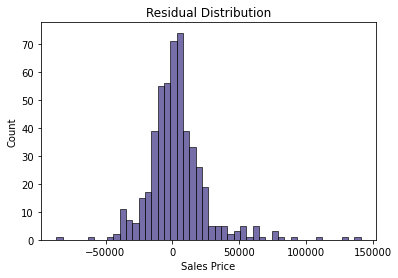

In [102]:
sns.histplot(residuals, color= 'darkslateblue');
plt.title('Residual Distribution');
plt.xlabel('Sales Price')
#slight right skew
plt.savefig('../visuals/residual_distribution.png', bbox_inches = 'tight')

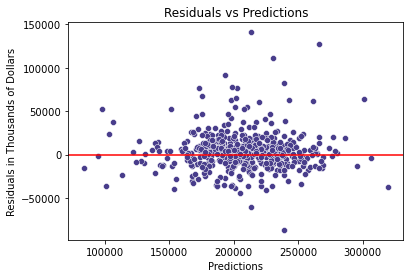

In [142]:
sns.scatterplot(x= preds,y=residuals, color = 'darkslateblue');
plt.title('Residuals vs Predictions');
plt.xlabel('Predictions');
plt.ylabel('Residuals in Thousands of Dollars');
plt.axhline(0, color = 'red')
plt.savefig('../visuals/residual_predictions.png', bbox_inches = 'tight')
#Variance honestly very homoschedastic, could always be better

In [112]:
features_coefs = pd.concat([pd.DataFrame(lr.coef_, columns = ['Coefficients']),
pd.DataFrame(selected_features, columns = ['selected_features'])], axis =1)

In [132]:
def unlog (val):
    if val>0:
        np.exp(val)
    else:
        np.exp(val)*-1
top_20 = features_coefs.sort_values(by ='Coefficients', ascending = False).head(20)
#top_10['Coefficients'] = np.exp(top_4['Coefficients']) #.map(unlog)

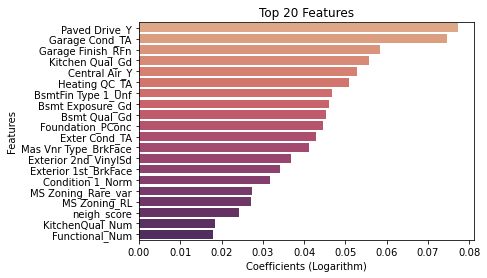

In [129]:
#np.exp(0.044505)
sns.barplot(x = top_20['Coefficients'], y = top_20['selected_features'], orient = 'h', palette = 'flare');
plt.title('Top 20 Features');
plt.xlabel('Coefficients (Logarithm)');
plt.ylabel('Features');
plt.savefig('../visuals/top_20.png', bbox_inches = 'tight')